In [2]:
# Modélisation des Émissions de CO2 et Évaluation de l'ENERGY STAR Score

In [4]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings


In [6]:
# Configuration de l'environnement
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_context("talk")

In [8]:
# Chargement des données prétraitées spécifiques aux émissions de CO2
try:
    # Chargement du fichier CSV créé pour les émissions de CO2
    donnees_co2 = pd.read_csv("donnees_emissions_co2_2015.csv")
    print(f"Données d'émissions de CO2 chargées avec succès: {donnees_co2.shape[0]} lignes et {donnees_co2.shape[1]} colonnes")
except FileNotFoundError:
    print("Fichier d'émissions de CO2 non trouvé. Tentative de chargement des données générales...")
    try:
        # Tentative de chargement du fichier général
        donnees_propres = pd.read_csv("donnees_propres_2015.csv")
        print(f"Données générales chargées: {donnees_propres.shape[0]} lignes et {donnees_propres.shape[1]} colonnes")
        
        # Identification de la colonne d'émissions de CO2
        colonne_co2 = None
        for col in donnees_propres.columns:
            if 'GHG' in col or 'CO2' in col or 'Emissions' in col:
                colonne_co2 = col
                break
        
        if colonne_co2:
            print(f"Colonne d'émissions de CO2 identifiée: {colonne_co2}")
            
            # Sélection des colonnes pertinentes pour l'analyse des émissions
            colonnes_importantes = [colonne_co2, 'PropertyGFABuilding(s)', 'YearBuilt']
            
            # Ajout d'autres colonnes pertinentes si disponibles
            autres_colonnes = ['PrimaryPropertyType', 'NumberofFloors', 'ENERGYSTARScore']
            for col in autres_colonnes:
                if col in donnees_propres.columns:
                    colonnes_importantes.append(col)
            
            # Création du dataframe pour les émissions
            donnees_co2 = donnees_propres[colonnes_importantes].copy()
            print("Données d'émissions extraites du jeu de données général")
        else:
            print("Aucune colonne d'émissions de CO2 n'a été identifiée dans les données")
            donnees_co2 = None
    except FileNotFoundError:
        print("Aucun fichier de données trouvé. Vérifiez les chemins d'accès.")
        donnees_co2 = None

Données d'émissions de CO2 chargées avec succès: 3340 lignes et 6 colonnes


In [10]:
# Affichage des premières lignes pour vérifier le contenu
if donnees_co2 is not None:
    donnees_co2.head()

In [12]:
# Analyse préliminaire des émissions de CO2 - Partie 1
# Identification de la variable cible d'émissions de CO2

if donnees_co2 is not None:
    # Identification de la colonne d'émissions de CO2
    col_co2 = None
    for col in donnees_co2.columns:
        if 'GHG' in col or 'CO2' in col or 'Emissions' in col:
            col_co2 = col
            break
    
    if col_co2:
        print(f"Variable cible identifiée: {col_co2}")
        
        # Statistiques descriptives
        print("\nStatistiques descriptives des émissions de CO2:")
        stats_co2 = donnees_co2[col_co2].describe()
        display(stats_co2)
    else:
        print("Aucune variable d'émissions de CO2 n'a été identifiée")
else:
    print("Aucune donnée disponible pour l'analyse")

Variable cible identifiée: GHGEmissions(MetricTonsCO2e)

Statistiques descriptives des émissions de CO2:


count    3330.00
mean      110.09
std       409.45
min         0.00
25%         9.27
50%        32.74
75%        88.64
max     11824.89
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

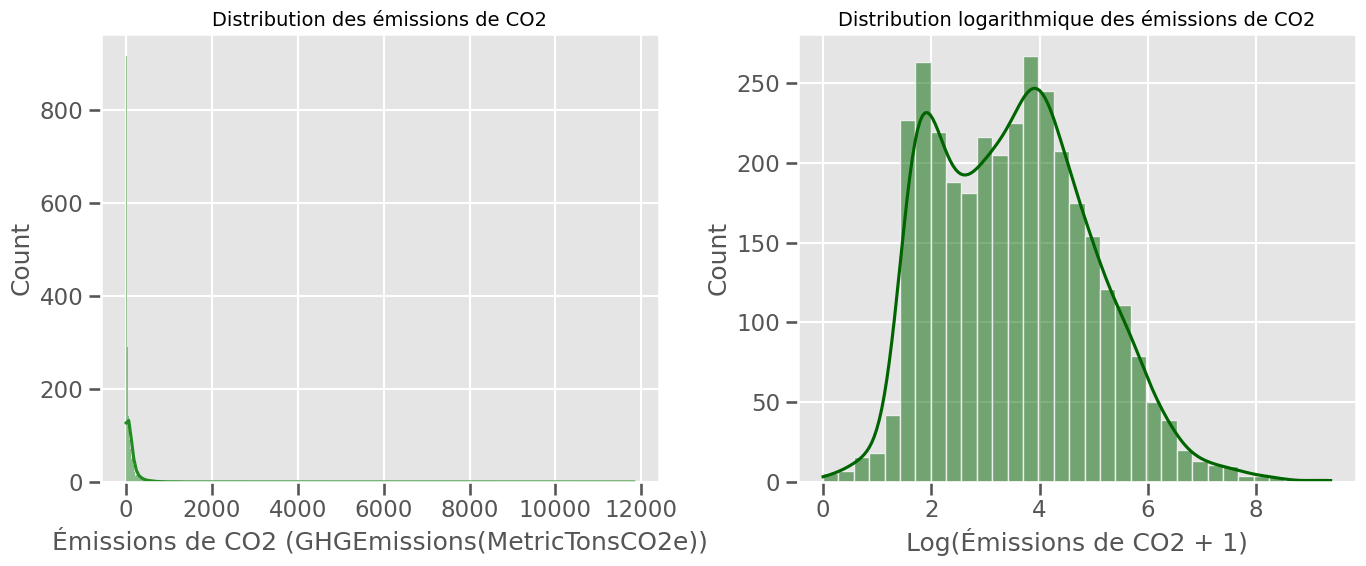

In [14]:
# Analyse préliminaire des émissions de CO2 - Partie 2
# Visualisation de la distribution des émissions

if donnees_co2 is not None and col_co2:
    # Visualisation de la distribution des émissions
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(donnees_co2[col_co2].dropna(), kde=True, color='forestgreen')
    plt.title('Distribution des émissions de CO2', fontsize=14)
    plt.xlabel(f'Émissions de CO2 ({col_co2})')
    
    # Transformation logarithmique pour mieux visualiser
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(donnees_co2[col_co2].dropna()), kde=True, color='darkgreen')
    plt.title('Distribution logarithmique des émissions de CO2', fontsize=14)
    plt.xlabel(f'Log(Émissions de CO2 + 1)')
    
    plt.tight_layout()
    plt.show()
    
    # Ajout de la variable transformée logarithmiquement
    donnees_co2['Log_CO2_Emissions'] = np.log1p(donnees_co2[col_co2])

In [16]:
# Analyse préliminaire des émissions de CO2 - Partie 3
# Analyse des corrélations avec d'autres variables

if donnees_co2 is not None and col_co2:
    # Analyse des corrélations avec d'autres variables
    print("\nExploration des relations avec les émissions de CO2:")
    
    # Sélection des variables numériques
    var_numeriques = []
    for col in donnees_co2.columns:
        if col != col_co2 and donnees_co2[col].dtype in ['int64', 'float64']:
            var_numeriques.append(col)
    
    # Matrice de corrélation
    if var_numeriques:
        corr_matrix = donnees_co2[[col_co2] + var_numeriques].corr()
        correlation_avec_co2 = corr_matrix[col_co2].sort_values(ascending=False)
        
        print("\nCorrélations avec les émissions de CO2:")
        print(correlation_avec_co2)


Exploration des relations avec les émissions de CO2:

Corrélations avec les émissions de CO2:
GHGEmissions(MetricTonsCO2e)    1.00
PropertyGFABuilding(s)          0.55
Log_CO2_Emissions               0.48
NumberofFloors                  0.19
YearBuilt                       0.04
ENERGYSTARScore                -0.10
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


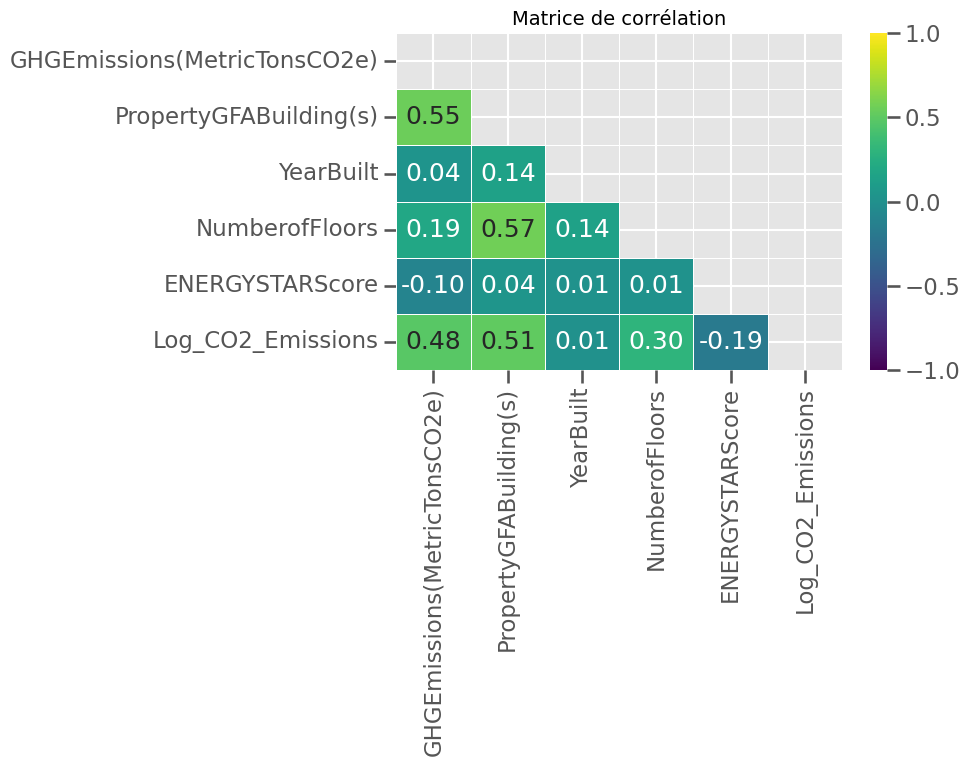

In [18]:
# Analyse préliminaire des émissions de CO2 - Partie 4
# Visualisation des corrélations

if donnees_co2 is not None and col_co2 and var_numeriques:
    # Visualisation des corrélations
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Matrice de corrélation', fontsize=14)
    plt.tight_layout()
    plt.show()

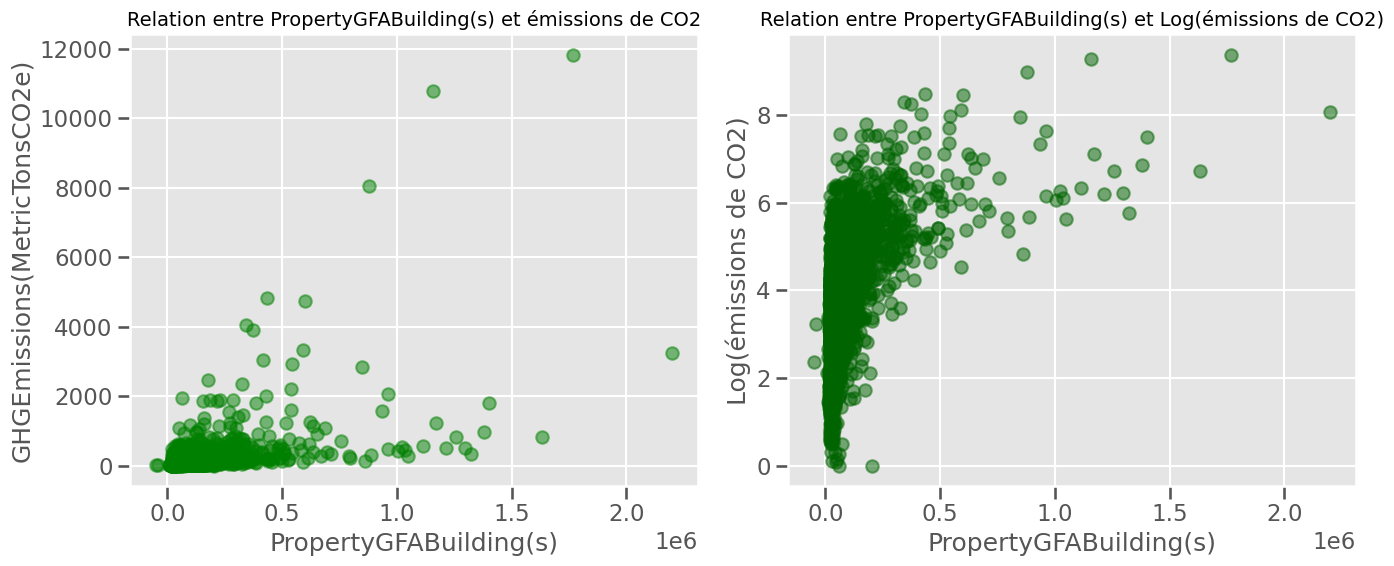

In [20]:
# Analyse préliminaire des émissions de CO2 - Partie 5
# Visualisation des relations avec la variable la plus corrélée

if donnees_co2 is not None and col_co2 and len(var_numeriques) > 0:
    # Visualisation des relations avec les variables les plus corrélées
    top_var = correlation_avec_co2.index[1]  # La première est la variable elle-même
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(donnees_co2[top_var], donnees_co2[col_co2], alpha=0.5, color='green')
    plt.title(f'Relation entre {top_var} et émissions de CO2', fontsize=14)
    plt.xlabel(top_var)
    plt.ylabel(col_co2)
    
    # Visualisation logarithmique
    plt.subplot(1, 2, 2)
    plt.scatter(donnees_co2[top_var], donnees_co2['Log_CO2_Emissions'], alpha=0.5, color='darkgreen')
    plt.title(f'Relation entre {top_var} et Log(émissions de CO2)', fontsize=14)
    plt.xlabel(top_var)
    plt.ylabel('Log(émissions de CO2)')
    
    plt.tight_layout()
    plt.show()

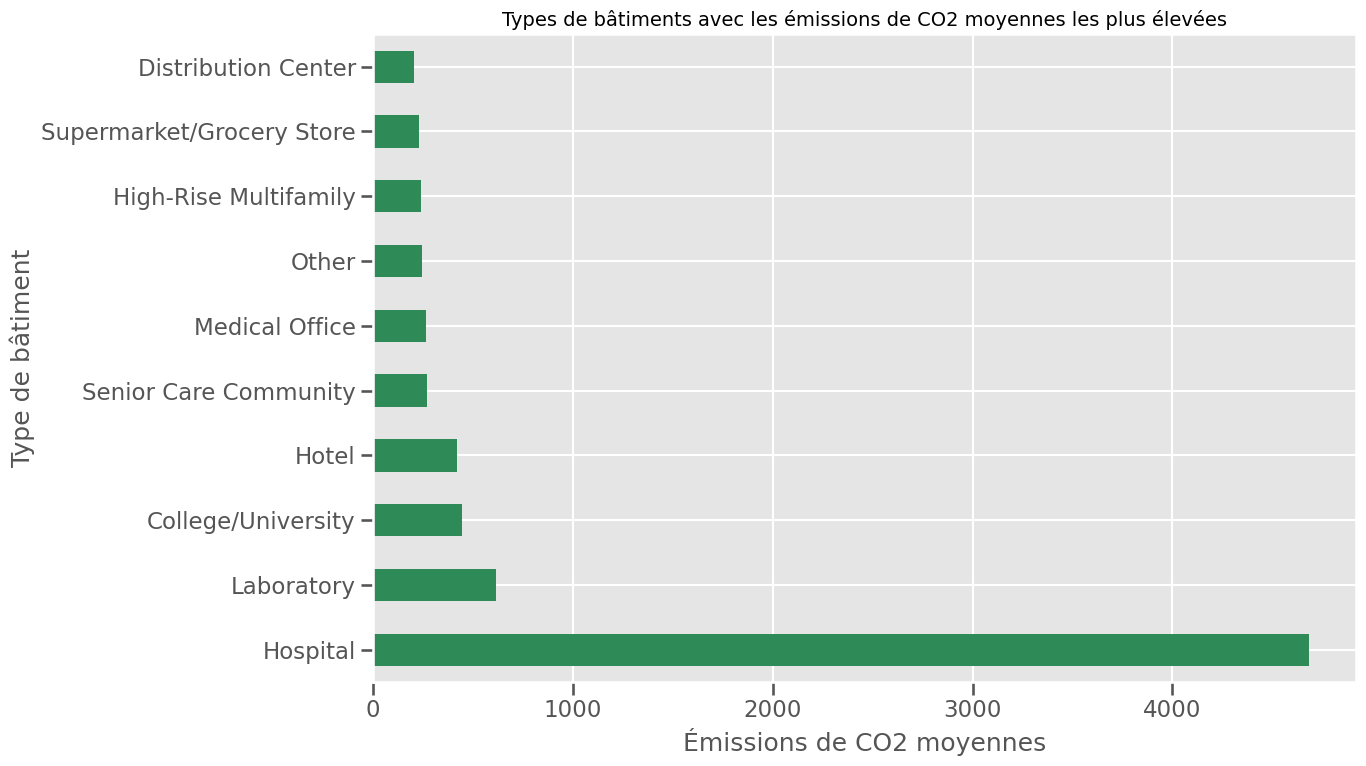

In [22]:
# Analyse préliminaire des émissions de CO2 - Partie 6
# Analyse par type de bâtiment

if donnees_co2 is not None and col_co2 and 'PrimaryPropertyType' in donnees_co2.columns:
    # Calcul des émissions moyennes par type de bâtiment
    emissions_par_type = donnees_co2.groupby('PrimaryPropertyType')[col_co2].mean().sort_values(ascending=False)
    
    # Visualisation des 10 types avec les émissions les plus élevées
    plt.figure(figsize=(14, 8))
    emissions_par_type.head(10).plot(kind='barh', color='seagreen')
    plt.title('Types de bâtiments avec les émissions de CO2 moyennes les plus élevées', fontsize=14)
    plt.xlabel('Émissions de CO2 moyennes')
    plt.ylabel('Type de bâtiment')
    plt.tight_layout()
    plt.show()

In [24]:
# Préparation des données pour la modélisation des émissions de CO2 - Partie 1
# Identification des variables explicatives

if donnees_co2 is not None and col_co2:
    print("Préparation des données pour la modélisation des émissions de CO2")
    
    # 1. Identification des variables explicatives
    colonnes_numeriques = []
    colonnes_categorielles = []
    
    for col in donnees_co2.columns:
        # Exclure la variable cible et les transformations
        if col != col_co2 and col != 'Log_CO2_Emissions':
            if donnees_co2[col].dtype in ['int64', 'float64']:
                colonnes_numeriques.append(col)
            elif donnees_co2[col].dtype == 'object':
                # Limiter le nombre de catégories
                if donnees_co2[col].nunique() < 30:
                    colonnes_categorielles.append(col)
    
    print(f"\nVariables numériques sélectionnées ({len(colonnes_numeriques)}):")
    print(colonnes_numeriques)
    
    print(f"\nVariables catégorielles sélectionnées ({len(colonnes_categorielles)}):")
    print(colonnes_categorielles)

Préparation des données pour la modélisation des émissions de CO2

Variables numériques sélectionnées (4):
['PropertyGFABuilding(s)', 'YearBuilt', 'NumberofFloors', 'ENERGYSTARScore']

Variables catégorielles sélectionnées (1):
['PrimaryPropertyType']


In [26]:
# Préparation des données pour la modélisation des émissions de CO2 - Partie 2
# Création des jeux d'entraînement et de test

if donnees_co2 is not None and col_co2:
    # 2. Suppression des lignes avec valeurs manquantes dans la cible
    donnees_modele = donnees_co2.dropna(subset=[col_co2]).copy()
    print(f"\nNombre de lignes après suppression des valeurs manquantes dans la cible: {len(donnees_modele)}")
    
    # 3. Création du jeu de données pour la modélisation
    X = donnees_modele[colonnes_numeriques + colonnes_categorielles]
    y = donnees_modele[col_co2]
    
    # 4. Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nDonnées divisées en {len(X_train)} échantillons d'entraînement et {len(X_test)} échantillons de test")


Nombre de lignes après suppression des valeurs manquantes dans la cible: 3330

Données divisées en 2664 échantillons d'entraînement et 666 échantillons de test


In [28]:
# Préparation des données pour la modélisation des émissions de CO2 - Partie 3
# Création du pipeline de prétraitement

if donnees_co2 is not None and col_co2:
    # 5. Création d'un pipeline de prétraitement
    # Préprocesseur pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Préprocesseur pour les variables catégorielles
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combinaison des préprocesseurs
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, colonnes_numeriques),
            ('cat', categorical_transformer, colonnes_categorielles)
        ])

In [30]:
# Préparation des données pour la modélisation des émissions de CO2 - Partie 4
# Définition de la fonction d'évaluation et des modèles à tester

if donnees_co2 is not None and col_co2:
    # Définition de la fonction d'évaluation des modèles
    def evaluer_modele(modele, X_train, X_test, y_train, y_test, nom):
        # Créer le pipeline complet
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', modele)
        ])
        
        # Entraînement
        pipeline.fit(X_train, y_train)
        
        # Prédictions
        y_pred = pipeline.predict(X_test)
        
        # Calcul des métriques
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\nPerformance du modèle {nom}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        
        return pipeline, rmse, r2
    
    # Modèles à tester
    modeles = {
        'Régression Linéaire': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

Évaluation de différents modèles pour la prédiction des émissions de CO2

--------------------------------------------------
Évaluation du modèle: Régression Linéaire

Performance du modèle Régression Linéaire:
RMSE: 205.45
MAE: 87.21
R²: 0.4622

--------------------------------------------------
Évaluation du modèle: Ridge

Performance du modèle Ridge:
RMSE: 194.14
MAE: 86.30
R²: 0.5198

--------------------------------------------------
Évaluation du modèle: Lasso

Performance du modèle Lasso:
RMSE: 203.10
MAE: 85.95
R²: 0.4744

--------------------------------------------------
Évaluation du modèle: Random Forest

Performance du modèle Random Forest:
RMSE: 224.85
MAE: 74.71
R²: 0.3558

--------------------------------------------------
Évaluation du modèle: Gradient Boosting

Performance du modèle Gradient Boosting:
RMSE: 208.06
MAE: 73.68
R²: 0.4484

--------------------------------------------------
Meilleur modèle: Ridge (R² = 0.5198)


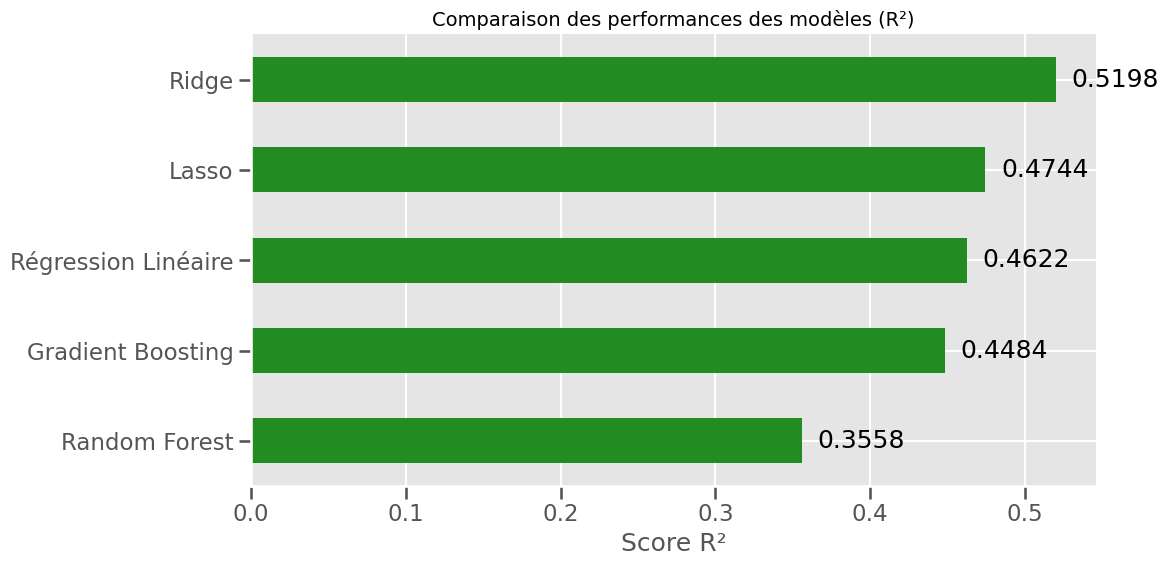

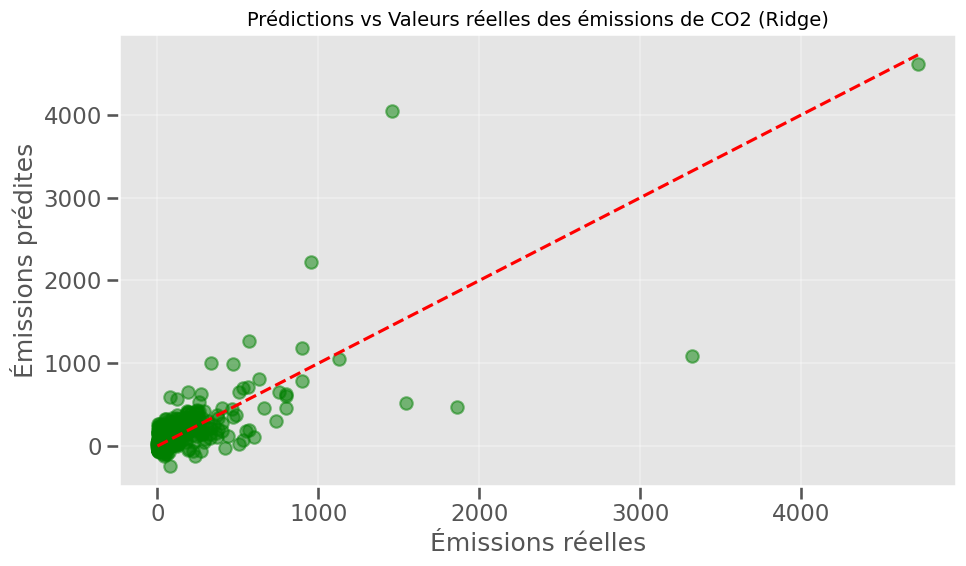

In [32]:
# Évaluation des modèles pour la prédiction des émissions de CO2

if 'modeles' in locals() and 'X_train' in locals():
    print("Évaluation de différents modèles pour la prédiction des émissions de CO2")
    
    # Évaluation des modèles
    resultats = {}
    pipelines = {}
    
    for nom, modele in modeles.items():
        print(f"\n{'-'*50}")
        print(f"Évaluation du modèle: {nom}")
        pipeline, rmse, r2 = evaluer_modele(modele, X_train, X_test, y_train, y_test, nom)
        resultats[nom] = {'RMSE': rmse, 'R²': r2}
        pipelines[nom] = pipeline
    
    # Sélection du meilleur modèle (basé sur R²)
    meilleur_modele = max(resultats, key=lambda x: resultats[x]['R²'])
    print(f"\n{'-'*50}")
    print(f"Meilleur modèle: {meilleur_modele} (R² = {resultats[meilleur_modele]['R²']:.4f})")
    
    # Visualisation des performances des modèles
    resultats_df = pd.DataFrame.from_dict(resultats, orient='index')
    
    plt.figure(figsize=(12, 6))
    ax = resultats_df['R²'].sort_values().plot(kind='barh', color='forestgreen')
    plt.title('Comparaison des performances des modèles (R²)', fontsize=14)
    plt.xlabel('Score R²')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(resultats_df['R²'].sort_values()):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')
        
    plt.tight_layout()
    plt.show()
    
    # Visualisation des prédictions vs valeurs réelles pour le meilleur modèle
    meilleur_pipeline = pipelines[meilleur_modele]
    y_pred = meilleur_pipeline.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Prédictions vs Valeurs réelles des émissions de CO2 ({meilleur_modele})', fontsize=14)
    plt.xlabel('Émissions réelles')
    plt.ylabel('Émissions prédites')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [34]:
# Optimisation des hyperparamètres du meilleur modèle

if 'meilleur_modele' in locals():
    print(f"\n{'-'*50}")
    print(f"Optimisation des hyperparamètres du modèle {meilleur_modele}")
    
    # Définition des grilles de paramètres selon le meilleur modèle
    if meilleur_modele == 'Régression Linéaire':
        param_grid = {
            'model__fit_intercept': [True, False]
        }
    elif meilleur_modele == 'Ridge':
        param_grid = {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    elif meilleur_modele == 'Lasso':
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    elif meilleur_modele == 'Random Forest':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10]
        }
    elif meilleur_modele == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    
    # Création du pipeline pour la recherche par grille
    pipeline_optimisation = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', modeles[meilleur_modele])
    ])
    
    # Recherche par grille avec validation croisée
    grid_search = GridSearchCV(
        pipeline_optimisation, 
        param_grid, 
        cv=5, 
        scoring='r2', 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score R² (validation croisée): {grid_search.best_score_:.4f}")
    
    # Évaluation du modèle optimisé sur l'ensemble de test
    y_pred_optimise = grid_search.predict(X_test)
    rmse_optimise = np.sqrt(mean_squared_error(y_test, y_pred_optimise))
    r2_optimise = r2_score(y_test, y_pred_optimise)
    
    print(f"\nPerformance du modèle optimisé sur l'ensemble de test:")
    print(f"RMSE: {rmse_optimise:.2f}")
    print(f"R²: {r2_optimise:.4f}")
    
    # Comparaison avant/après optimisation
    print(f"\nAmélioration du R² après optimisation: {r2_optimise - resultats[meilleur_modele]['R²']:.4f}")
    
    # Analyse de l'importance des variables (si applicable)
    if meilleur_modele in ['Random Forest', 'Gradient Boosting']:
        print(f"\n{'-'*50}")
        print(f"Analyse de l'importance des variables avec {meilleur_modele}")
        
        # Extraction du modèle entraîné
        modele_final = grid_search.best_estimator_.named_steps['model']
        
        # Récupération des noms de variables après transformation
        preprocessor_optimise = grid_search.best_estimator_.named_steps['preprocessor']
        
        # Obtention des noms de colonnes pour les variables numériques
        colonnes_transformees_num = colonnes_numeriques
        
        # Obtention des noms de colonnes pour les variables catégorielles
        colonnes_transformees_cat = []
        if len(colonnes_categorielles) > 0:
            try:
                # Extraction des noms de colonnes catégorielles transformées
                ohe = preprocessor_optimise.named_transformers_['cat'].named_steps['onehot']
                ohe.fit(X_train[colonnes_categorielles].fillna('missing'))
                colonnes_transformees_cat = ohe.get_feature_names_out(colonnes_categorielles).tolist()
            except:
                print("Impossible d'extraire les noms de colonnes catégorielles transformées")
        
        # Combinaison des noms de colonnes
        toutes_colonnes = colonnes_transformees_num + colonnes_transformees_cat
        
        # Extraction et tri des importances
        importances = modele_final.feature_importances_
        
        # Si le nombre d'importances correspond exactement au nombre de colonnes
        if len(importances) == len(toutes_colonnes):
            indices = np.argsort(importances)[::-1]
            
            # Affichage des variables les plus importantes
            plt.figure(figsize=(12, 8))
            plt.title(f'Importance des variables - {meilleur_modele}', fontsize=14)
            plt.barh(range(min(20, len(indices))), importances[indices][:20], align='center', color='darkgreen')
            plt.yticks(range(min(20, len(indices))), [toutes_colonnes[i] for i in indices][:20])
            plt.gca().invert_yaxis()  # Les plus importantes en haut
            plt.xlabel('Importance relative')
            plt.tight_layout()
            plt.show()
            
            # Tableau des importances
            importance_df = pd.DataFrame({
                'Variable': toutes_colonnes,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print("\nTop 10 des variables les plus importantes pour la prédiction des émissions de CO2:")
            print(importance_df.head(10))
        else:
            print(f"Incompatibilité des dimensions: {len(importances)} importances vs {len(toutes_colonnes)} colonnes")


--------------------------------------------------
Optimisation des hyperparamètres du modèle Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Meilleurs paramètres: {'model__alpha': 1.0}
Meilleur score R² (validation croisée): 0.3199

Performance du modèle optimisé sur l'ensemble de test:
RMSE: 194.14
R²: 0.5198

Amélioration du R² après optimisation: 0.0000



--------------------------------------------------
Analyse spécifique de l'ENERGY STAR Score pour la prédiction des émissions de CO2

Performance du modèle utilisant uniquement l'ENERGY STAR Score:
RMSE: 545.32
R²: 0.0032

Différence de R² par rapport au meilleur modèle: 0.5166


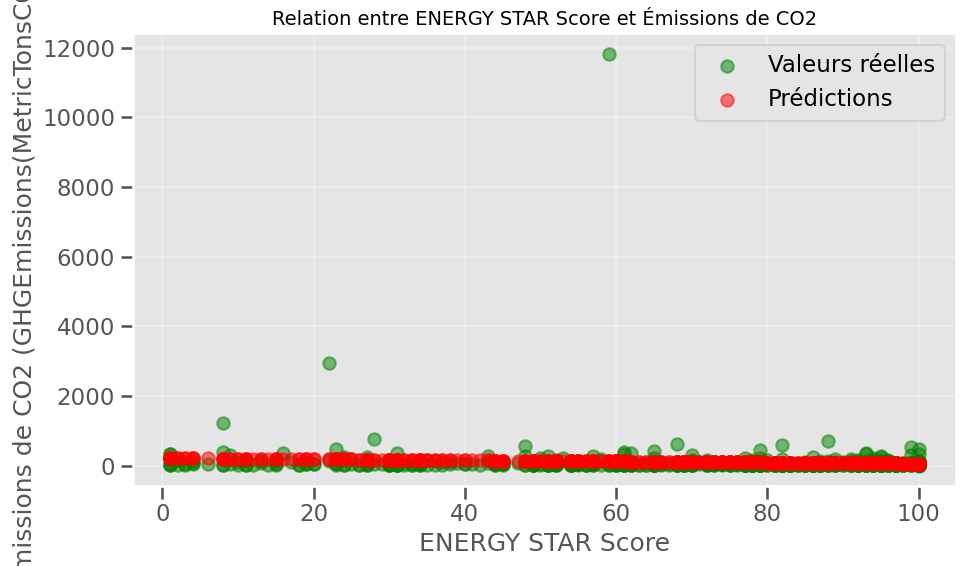


Conclusion: L'ENERGY STAR Score seul a une faible valeur prédictive pour les émissions de CO2


In [36]:
# Analyse spécifique de l'ENERGY STAR Score pour les émissions de CO2

if 'donnees_modele' in locals() and 'ENERGYSTARScore' in donnees_modele.columns:
    print(f"\n{'-'*50}")
    print(f"Analyse spécifique de l'ENERGY STAR Score pour la prédiction des émissions de CO2")
    
    # Création d'un modèle utilisant uniquement l'ENERGY STAR Score
    X_es = donnees_modele[['ENERGYSTARScore']].dropna()
    y_es = donnees_modele.loc[X_es.index, col_co2]
    
    # Division en ensembles d'entraînement et de test
    X_es_train, X_es_test, y_es_train, y_es_test = train_test_split(X_es, y_es, test_size=0.2, random_state=42)
    
    # Préprocesseur simplifié
    preprocessor_es = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Modèle linéaire simple
    modele_es = LinearRegression()
    
    # Pipeline
    pipeline_es = Pipeline(steps=[
        ('preprocessor', preprocessor_es),
        ('model', modele_es)
    ])
    
    # Entraînement
    pipeline_es.fit(X_es_train, y_es_train)
    
    # Prédictions
    y_es_pred = pipeline_es.predict(X_es_test)
    
    # Évaluation
    rmse_es = np.sqrt(mean_squared_error(y_es_test, y_es_pred))
    r2_es = r2_score(y_es_test, y_es_pred)
    
    print(f"\nPerformance du modèle utilisant uniquement l'ENERGY STAR Score:")
    print(f"RMSE: {rmse_es:.2f}")
    print(f"R²: {r2_es:.4f}")
    
    # Comparaison avec le meilleur modèle optimisé
    if 'r2_optimise' in locals():
        print(f"\nDifférence de R² par rapport au meilleur modèle: {r2_optimise - r2_es:.4f}")
    
    # Visualisation de la relation
    plt.figure(figsize=(10, 6))
    plt.scatter(X_es_test, y_es_test, alpha=0.5, color='green', label='Valeurs réelles')
    plt.scatter(X_es_test, y_es_pred, alpha=0.5, color='red', label='Prédictions')
    plt.title('Relation entre ENERGY STAR Score et Émissions de CO2', fontsize=14)
    plt.xlabel('ENERGY STAR Score')
    plt.ylabel(f'Émissions de CO2 ({col_co2})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Conclusion sur l'utilité de l'ENERGY STAR Score
    if r2_es < 0.3:
        conclusion_es = "L'ENERGY STAR Score seul a une faible valeur prédictive pour les émissions de CO2"
    elif r2_es < 0.6:
        conclusion_es = "L'ENERGY STAR Score a une valeur prédictive modérée pour les émissions de CO2"
    else:
        conclusion_es = "L'ENERGY STAR Score est un bon prédicteur des émissions de CO2, même utilisé seul"
    
    print(f"\nConclusion: {conclusion_es}")

In [42]:
# Conclusions et recommandations pour les émissions de CO2

if 'resultats' in locals():
    print(f"\n{'-'*50}")
    print(f"CONCLUSIONS ET RECOMMANDATIONS")
    print(f"{'-'*50}")
    
    print("\n1. Performances des modèles de prédiction des émissions de CO2:")
    for nom, perf in sorted(resultats.items(), key=lambda x: x[1]['R²'], reverse=True):
        print(f"   - {nom}: R² = {perf['R²']:.4f}")
    
    print(f"\n2. Meilleur modèle après optimisation:")
    print(f"   - {meilleur_modele} avec un R² de {r2_optimise:.4f}")
    
    if 'ENERGYSTARScore' in donnees_modele.columns and 'r2_es' in locals():
        print(f"\n3. Évaluation de l'ENERGY STAR Score pour les émissions de CO2:")
        print(f"   - R² comme prédicteur unique: {r2_es:.4f}")
        print(f"   - {conclusion_es}")
        
        if r2_es > 0.5:
            recommandation_es = "L'utilisation de l'ENERGY STAR Score est recommandée comme variable prédictive importante pour les émissions de CO2"
        elif r2_es > 0.3:
            recommandation_es = "L'ENERGY STAR Score peut être utile en complément d'autres variables pour prédire les émissions de CO2"
        else:
            recommandation_es = "L'ENERGY STAR Score seul n'est pas suffisant pour prédire les émissions de CO2"
        
        print(f"   - Recommandation: {recommandation_es}")
    
    print("\n4. Recommandations pour la ville de Seattle:")
    print("   - Utiliser le modèle", meilleur_modele, "pour estimer les émissions de CO2 des bâtiments")
    print("     non mesurés")
    if 'importance_df' in locals():
        print("   - Se concentrer sur la collecte des données pour les variables identifiées comme")
        print("     les plus importantes:", ", ".join(importance_df['Variable'].head(3).tolist()))
    print("   - Mettre en place une stratégie de mesure ciblée pour les bâtiments ayant")
    print("     les caractéristiques associées à des émissions élevées")
    print("   - Développer des politiques d'efficacité carbone basées sur les facteurs")
    print("     les plus influents identifiés par le modèle")
    
    print("\n5. Comparaison avec l'analyse de la consommation énergétique:")
    print("   - Analyser les similitudes et différences entre les facteurs influençant la consommation")
    print("     énergétique et les émissions de CO2")
    print("   - Évaluer si les mêmes types de bâtiments sont concernés par les deux problématiques")
    print("   - Identifier les leviers d'action prioritaires pour réduire à la fois la consommation")
    print("     énergétique")


--------------------------------------------------
CONCLUSIONS ET RECOMMANDATIONS
--------------------------------------------------

1. Performances des modèles de prédiction des émissions de CO2:
   - Ridge: R² = 0.5198
   - Lasso: R² = 0.4744
   - Régression Linéaire: R² = 0.4622
   - Gradient Boosting: R² = 0.4484
   - Random Forest: R² = 0.3558

2. Meilleur modèle après optimisation:
   - Ridge avec un R² de 0.5198

3. Évaluation de l'ENERGY STAR Score pour les émissions de CO2:
   - R² comme prédicteur unique: 0.0032
   - L'ENERGY STAR Score seul a une faible valeur prédictive pour les émissions de CO2
   - Recommandation: L'ENERGY STAR Score seul n'est pas suffisant pour prédire les émissions de CO2

4. Recommandations pour la ville de Seattle:
   - Utiliser le modèle Ridge pour estimer les émissions de CO2 des bâtiments
     non mesurés
   - Mettre en place une stratégie de mesure ciblée pour les bâtiments ayant
     les caractéristiques associées à des émissions élevées
   - 